In [22]:
from bs4 import BeautifulSoup
import csv
import re
import glob
import pandas as pd
import math
import matplotlib

In [23]:
# define output file name
output_file = "agg_result.csv"
input_files = "kungalv_slutpriser/kungalv_slutpris_page_*.html"

In [24]:
# create output file
with open(output_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(
        [
            "sold_on",
            "address",
            "location",
            "boarea",
            "biarea",
            "rooms",
            "plot_area",
            "closing_price",
            "totalarea",
        ]
    )

In [25]:
# get sold date
def get_sold_date(main_elm):
    pattern = r"(\d{4})"

    for elm in main_elm.find_all(
        "span", class_="hcl-label hcl-label--state hcl-label--sold-at"
    ):
        if elm:
            text = elm.get_text(separator=" ", strip=True)
            match = re.search(pattern, text)
            if match:
                return match.group(1).strip()

In [26]:
# get address
def get_address_date(main_elm):
    for elm in main_elm.find_all(
        "h2",
        class_="sold-property-listing__heading qa-selling-price-title hcl-card__title",
    ):
        return elm.text.strip()

In [27]:
# plot location
def get_location(main_elm):
    for elm in main_elm.find_all(
        "span",
        class_="property-icon property-icon--result",
    ):

        return "".join([line.strip() for line in elm.next_sibling.splitlines()])

In [28]:
# get plot area
def get_plot_area(main_elm):
    pattern = r"\s*(.*)\s*m²\s*tomt"
    for elm in main_elm.find_all(
        "div",
        class_="sold-property-listing__land-area",
    ):
        if elm:
            text = elm.get_text(separator=" ", strip=True)
            match = re.search(pattern, text)
            if match:
                # remove non break character
                return match.group(1).replace("\xa0", "").strip()

In [29]:
# get closing price
def get_closing_price(main_elm):
    pattern = r"Slutpris\s*(.*)\s*kr"
    for elm in main_elm.find_all("span", class_="hcl-text hcl-text--medium"):
        if elm:
            text = elm.get_text(separator=" ", strip=True)
            match = re.search(pattern, text)
            if match:
                # remove non break character
                return match.group(1).replace("\xa0", "").strip()

In [30]:
# get living area, storage area and rooms
def get_area(main_elm):
    main_area = ""
    additional_area = ""
    rooms = ""
    pattern = r"(?:(\d+)\s*(?:\+\s*(\d+))?\s*m²)?\s*(?:(\d+)\s*rum)?"
    for div in main_elm.find_all(
        "div", class_="sold-property-listing__subheading sold-property-listing__area"
    ):
        if div:
            text = div.get_text(separator=" ", strip=True)
            match = re.search(pattern, text)

            if match:
                # print("text",text)
                main_area = match.group(1)
                additional_area = match.group(2) if match.group(2) else None
                rooms = match.group(3) if match.group(3) else None
                return main_area, additional_area, rooms
            else:
                print("no match", text)
                print("full div", div)
                print("main elm", main_elm)

In [31]:
# write to csv file
def write_to_csv(data):
    with open(output_file, mode="a", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerows(data)

In [32]:
for file_path in glob.glob(input_files):
    #'kungalv_slutpriser/kungalv_slutpris_page_04.html'
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, "html.parser")
    units = soup.find_all(
        "div",
        {"class": "qa-sale-card hcl-grid hcl-grid--columns-1 hcl-grid--md-columns-2"},
    )

    file_data = list()
    # print(f"file {file_path} has {len(units)} data points")
    for main_elm in units:
        s_data = list()
        sold_date = get_sold_date(main_elm)
        address = get_address_date(main_elm)
        location = get_location(main_elm)
        area = get_area(main_elm)
        boarea = area[0]
        biarea = area[1]
        rooms = area[2]
        plot_size = get_plot_area(main_elm)
        closing_price = get_closing_price(main_elm)
        totalarea = (int(boarea) if boarea is not None else 0) + (
            int(biarea) if biarea is not None else 0
        )

        s_data.append(sold_date)
        s_data.append(address)
        s_data.append(location)
        s_data.append(boarea)
        s_data.append(biarea)
        s_data.append(rooms)
        s_data.append(plot_size)
        s_data.append(closing_price)
        s_data.append(totalarea)
        file_data.append(s_data)

    write_to_csv(file_data)

In [33]:
# load csv
raw_data = pd.read_csv(output_file)
agg_df = raw_data[raw_data["sold_on"] == 2022]

agg_df.dtypes

sold_on            int64
address           object
location          object
boarea           float64
biarea           float64
rooms            float64
plot_area         object
closing_price      int64
totalarea          int64
dtype: object

In [34]:
agg_df.head()

,sold_on,address,location,boarea,biarea,rooms,plot_area,closing_price,totalarea
121,2022,Långdammsvägen 2,"Marstrandsön,Kungälvs kommun",28.0,NaN,NaN,617,7125000,28
122,2022,Munkegärdegatan 312,"Munkegärde,Kungälvs kommun",170.0,NaN,6.0,612,5605000,170
123,2022,Bremnäs 130,"Lycke,Kungälvs kommun",167.0,40.0,8.0,938,4490000,207
124,2022,Bremnäs 155,"Lycke Bremnäs,Kungälvs kommun",137.0,53.0,6.0,1298,4125000,190
125,2022,Skurhagagatan 3,"Komarken,Kungälvs kommun",127.0,125.0,6.0,603,4700000,252


In [35]:
# Calculate five-number summary
# 1)sample minimum
agg_df["closing_price"].min()

np.int64(1650000)

In [36]:
# 2) sample median
agg_df["closing_price"].median()

np.float64(5000000.0)

In [37]:
# 3)sample maximum
agg_df["closing_price"].max()

np.int64(10500000)

In [38]:
# 4,5) quartile
# https://stackoverflow.com/questions/45926230/how-to-calculate-1st-and-3rd-quartiles
# 0.25 is first quartile
# 0.75 is third quartile
agg_df.closing_price.quantile([0.25, 0.75])

0.25    4012500.0
0.75    5795000.0
Name: closing_price, dtype: float64

In [39]:
# https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
total_datapoints = agg_df["closing_price"].count()
math.sqrt(total_datapoints)

13.784048752090222

<Axes: title={'center': 'Closing Price Histogram'}, xlabel='Closing Price (SEK) in Log scale', ylabel='Number of Houses'>

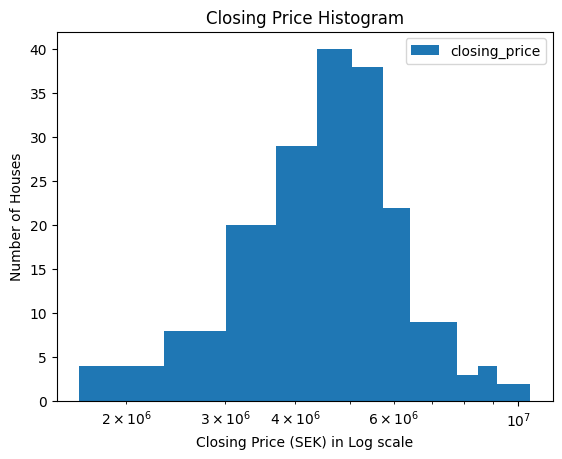

In [47]:
agg_df.plot(
    kind="hist",
    title="Closing Price Histogram",
    xlabel="Closing Price (SEK) in Log scale",
    ylabel="Number of Houses",
    column="closing_price",
    logx=True,
    bins=13,
)

<Axes: title={'center': 'Relation Between Closing Price and boarea'}, xlabel='Closing Price (SEK) in Log Scale', ylabel='boarea (m²)'>

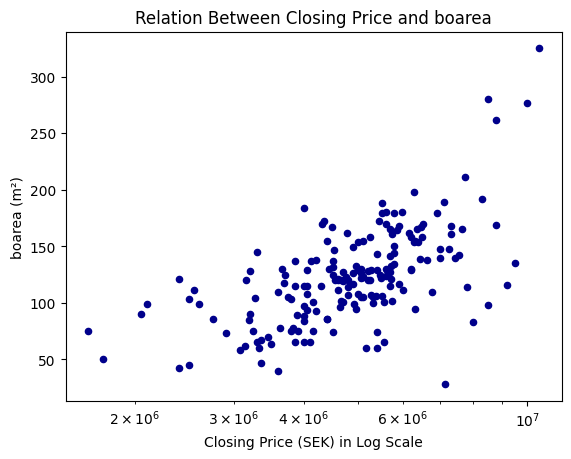

In [48]:
agg_df.plot(
    kind="scatter",
    title="Relation Between Closing Price and boarea",
    xlabel="Closing Price (SEK) in Log Scale",
    ylabel="boarea (m²)",
    logx=True,
    x="closing_price",
    y="boarea",
    c="DarkBlue",
)

<Axes: title={'center': 'Relation Between Closing Price and boarea'}, xlabel='Closing Price (SEK) in Log scale', ylabel='boarea (m²)'>

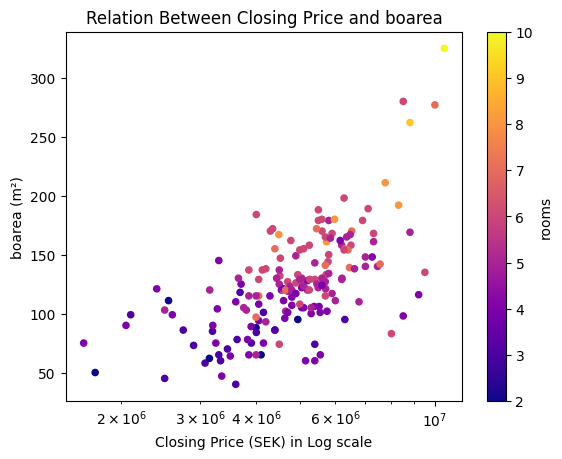

In [49]:
agg_df.plot(
    kind="scatter",
    title="Relation Between Closing Price and boarea",
    xlabel="Closing Price (SEK) in Log scale",
    ylabel="boarea (m²)",
    x="closing_price",
    logx=True,
    y="boarea",
    c="rooms",
    cmap="plasma",
    colorbar=True,
)